# Foundations of Data Science Project
## Phase 2: Sentiment Analysis
### By Arad Mahdinejad Kashani - 400102028
#### February 2024

**Reading the data:**

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [17]:
path = '/kaggle/input/training1600000processednoemoticoncsv/training.1600000.processed.noemoticon.csv'
df = pd.read_csv(path, encoding='latin-1',
                 names=['label', 'id', 'datetime', 'QUERY', 'user', 'tweet'])
df.drop('QUERY', axis=1, inplace=True)
df.head()

,label,id,datetime,user,tweet
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,Karoli,"@nationwideclass no, it's not behaving at all...."


In [104]:
sample_size=100_000
df_sampled = df.sample(n=sample_size)
df_sampled

,label,id,datetime,user,tweet
307406,0,2000466226,Mon Jun 01 22:10:41 PDT 2009,kristlesegui,"I lost the other half of earring, that Ben and..."
1538436,4,2179876339,Mon Jun 15 09:42:18 PDT 2009,CHACITY,@lalavazquez New Hairstyle is cute! Awww Come...
1501556,4,2071479293,Sun Jun 07 19:27:51 PDT 2009,emeraldashlee,@LpThePharaoh it wass fuuunnnn me &amp; @chan...
1558040,4,2185736001,Mon Jun 15 17:49:44 PDT 2009,glags91,@xonoelbabe I just read your blog thingy..... ...
194860,0,1970382531,Sat May 30 03:38:32 PDT 2009,BrandonTFerris,Cant sleep just sitting around bored
...,...,...,...,...,...
696281,0,2253480979,Sat Jun 20 08:14:33 PDT 2009,cocacolin,just realized that I'll be missing both of my ...
383135,0,2053136801,Sat Jun 06 03:25:07 PDT 2009,underhill70,Bummed out because I missed out getting ticket...
738781,0,2265557438,Sun Jun 21 06:50:35 PDT 2009,MaddyjH,said scarf/hat/glove is lost
58108,0,1685822744,Sun May 03 02:15:55 PDT 2009,shainamaydel,i was under the impression that there was neve...


In [105]:
from dateutil import parser
import pytz

def convert_to_datetime(dt_str):
    # Remove timezone from string
    dt_str = dt_str.rsplit(" ", 1)[0]
    # Convert string to datetime
    dt = parser.parse(dt_str)
    # Localize to PDT
    dt = dt.replace(tzinfo=pytz.timezone('US/Pacific'))
    return dt

# Apply the function to the 'datetime' column
df_sampled['datetime'] = df_sampled['datetime'].apply(convert_to_datetime)

df_sampled.head()

/opt/conda/lib/python3.10/site-packages/dateutil/parser/_parser.py:1207: UnknownTimezoneWarning: tzname PDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "


,label,id,datetime,user,tweet
307406,0,2000466226,2024-06-01 23:03:41-07:00,kristlesegui,"I lost the other half of earring, that Ben and..."
1538436,4,2179876339,2024-06-15 10:35:18-07:00,CHACITY,@lalavazquez New Hairstyle is cute! Awww Come...
1501556,4,2071479293,2024-06-07 20:20:51-07:00,emeraldashlee,@LpThePharaoh it wass fuuunnnn me &amp; @chan...
1558040,4,2185736001,2024-06-15 18:42:44-07:00,glags91,@xonoelbabe I just read your blog thingy..... ...
194860,0,1970382531,2024-05-30 04:31:32-07:00,BrandonTFerris,Cant sleep just sitting around bored


*Clean the data.*
* *Removing duplicate values and useless data (both columns and rows).*
* *Handling upper/lower case, etc.*

In [8]:
#%pip install wordninja

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 541.6/541.6 kB 3.4 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Created wheel for wordninja: filename=wordninja-2.0.0-py3-none-any.whl size=541529 sha256=a460585474ac1c894b9aa809ec00608e6f5727d465b84ae9cfa409761ee3472c
  Stored in directory: /root/.cache/pip/wheels/aa/44/3a/f2a5c1859b8b541ded969b4cd12d0a58897f12408f4f51e084
Successfully built wordninja
Note: you may need to restart the kernel to use updated packages.


In [106]:
import re
import string
from nltk.corpus import stopwords
import wordninja
from nltk.tokenize import word_tokenize

stop_words = set(stopwords.words('english'))
# We want to remove URLs - @ and # signs - stopwords such as: 'is', 'at', 'which, digits and non-ASCII letters

def preprocess_tweet(tweet):
    tweet = re.sub(r"http\S+|www\S+|https\S+", '', tweet, flags=re.MULTILINE)
    tweet = re.sub(r'\@\w+','', tweet)
    
    hashtags = re.findall(r"\#(\w+)", tweet)
    
    split_hashtags = [' '.join(wordninja.split(hashtag)) for hashtag in hashtags]
    
    for original, split in zip(hashtags, split_hashtags):
        tweet = tweet.replace('#' + original, split)

    tweet = tweet.translate(str.maketrans('', '', string.punctuation))
    tweet = re.sub('[^a-zA-Z]', ' ', tweet)
    
    tweet_tokens = word_tokenize(tweet)
    filtered_words = [w for w in tweet_tokens if not w in stop_words and w.isascii()]


    return (" ".join(filtered_words)).lower()

df_sampled['tweet_filtered'] = df_sampled['tweet'].apply(preprocess_tweet)
df_sampled

,label,id,datetime,user,tweet,tweet_filtered
307406,0,2000466226,2024-06-01 23:03:41-07:00,kristlesegui,"I lost the other half of earring, that Ben and...",i lost half earring ben i share inside lightle...
1538436,4,2179876339,2024-06-15 10:35:18-07:00,CHACITY,@lalavazquez New Hairstyle is cute! Awww Come...,new hairstyle cute awww come salon lala lol
1501556,4,2071479293,2024-06-07 20:20:51-07:00,emeraldashlee,@LpThePharaoh it wass fuuunnnn me &amp; @chan...,wass fuuunnnn amp hadda good time
1558040,4,2185736001,2024-06-15 18:42:44-07:00,glags91,@xonoelbabe I just read your blog thingy..... ...,i read blog thingy im gon na fight with jen ha...
194860,0,1970382531,2024-05-30 04:31:32-07:00,BrandonTFerris,Cant sleep just sitting around bored,cant sleep sitting around bored
...,...,...,...,...,...,...
696281,0,2253480979,2024-06-20 09:07:33-07:00,cocacolin,just realized that I'll be missing both of my ...,realized ill missing best friends birthdays im...
383135,0,2053136801,2024-06-06 04:18:07-07:00,underhill70,Bummed out because I missed out getting ticket...,bummed i missed getting tickets muse liverpool
738781,0,2265557438,2024-06-21 07:43:35-07:00,MaddyjH,said scarf/hat/glove is lost,said scarfhatglove lost
58108,0,1685822744,2024-05-03 03:08:55-07:00,shainamaydel,i was under the impression that there was neve...,impression never rain israel pesach apparently...


In [21]:
df_sampled.to_csv('/kaggle/working/df_sampled.csv', index=False)

I am switching to GPU here.

In [15]:
#df_sampled = pd.read_csv('/kaggle/working/df_sampled.csv', encoding='latin-1',
#                 names=['label', 'id', 'datetime', 'QUERY', 'user', 'tweet'])
#df_sampled

,label,id,datetime,QUERY,user,tweet
0,label,id,datetime,QUERY,user,tweet
1,label,id,datetime,user,tweet,tweet_filtered
2,0,1964650535,2024-05-29 15:27:44-07:00,nutburgers,I wanna feel my chin,i wan na feel chin
3,4,1573966944,2024-04-21 04:34:27-07:00,adriandario,what a beautiful day shame being at work :-$,beautiful day shame work
4,4,2055210214,2024-06-06 09:47:25-07:00,Mandykoi,looking forward to a nice relaxing weekend bu...,looking forward nice relaxing weekend fast go
...,...,...,...,...,...,...
99997,0,1975878609,2024-05-30 16:58:56-07:00,coooney,Its a shame Jack &amp; Vera aren't married irl...,its shame jack amp vera arent married irl way ...
99998,4,1983469450,2024-05-31 14:05:57-07:00,phpworker,of course I like it ÃÂ¢ÃÂÃÂ« http://blip....,course i like
99999,0,2197239910,2024-06-16 14:24:32-07:00,TisDN,"@DJHeatDC thanx, but no luck Guess I'll just ...",thanx luck guess ill use imagination
100000,4,1881042114,2024-05-22 04:17:00-07:00,ManiKarthik,@leeboone Pleasure Lee,pleasure lee


In [22]:
from sklearn.model_selection import train_test_split

corpus = df_sampled['tweet_filtered']
labels = df_sampled['label']

x_train, x_test, y_train, y_test = train_test_split(corpus, labels, test_size=0.1, random_state=42)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.11, random_state=42)

# BOW

In [23]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(max_features=1000)
x_train_bow = cv.fit_transform(x_train)
x_test_bow = cv.fit_transform(x_test)
x_valid_bow = cv.fit_transform(x_valid)

x_train_bow.shape, x_valid_bow.shape, x_test_bow.shape

((80100, 1000), (9900, 1000), (10000, 1000))

### SVM

In [24]:
from sklearn.svm import SVC

svc = SVC(random_state=42)

svc.fit(x_train_bow, y_train)

SVC(random_state=42)

In [25]:
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

y_tr_pred = svc.predict(x_train_bow)
y_va_pred = svc.predict(x_valid_bow)
y_te_pred = svc.predict(x_test_bow)

In [29]:
acc_train = accuracy_score(y_train, y_tr_pred)
acc_valid = accuracy_score(y_valid, y_va_pred)
acc_test = accuracy_score(y_test, y_te_pred)

print(f'Train accuracy: {acc_train*100:.2f}%')
print(f'Validation accuracy: {acc_valid*100:.2f}%\n')
print(f'Test accuracy: {acc_test*100:.2f}%\n')

Train accuracy: 86.71%
Validation accuracy: 52.25%

Test accuracy: 51.77%



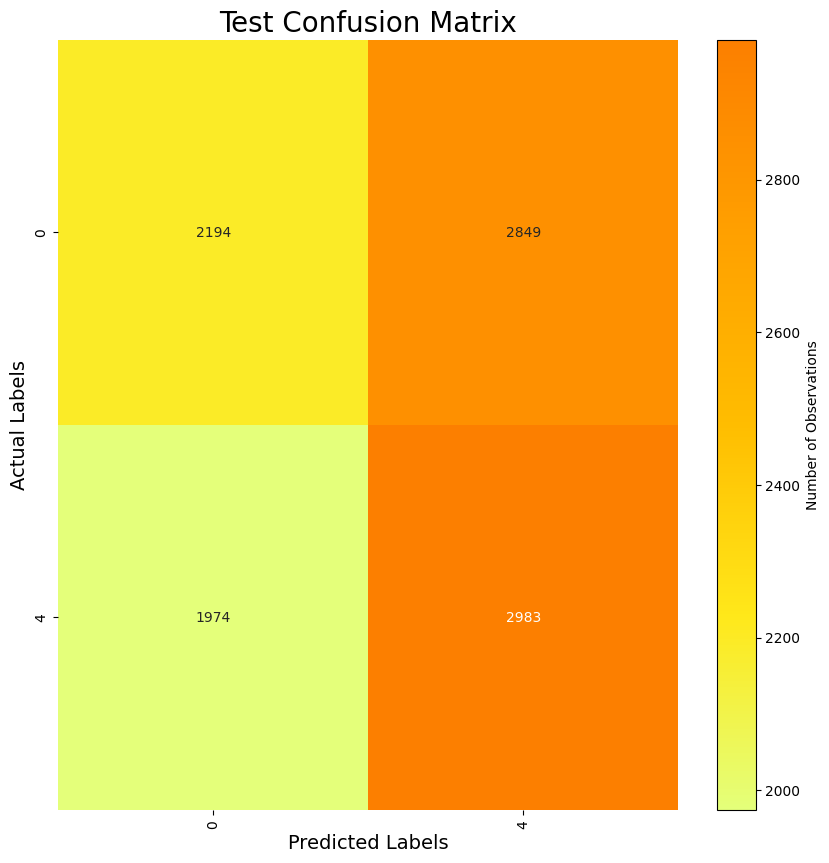

In [35]:
cm_test = confusion_matrix(y_test, y_te_pred)

cm_df = pd.DataFrame(cm_test, columns=np.unique(y_test), index = np.unique(y_test))
cm_df.index.name = 'Actual'
cm_df.columns.name = 'Predicted'

fig, ax = plt.subplots(figsize=(10, 10))

sns.heatmap(cm_df, annot=True, fmt='d', cmap='Wistia', ax=ax, cbar=False)

cbar = ax.figure.colorbar(ax.collections[0])
cbar.set_label('Number of Observations')

plt.title('Test Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)

ax.set_xticks(np.arange(cm_df.shape[1]) + 0.5, minor=False)
ax.set_yticks(np.arange(cm_df.shape[0]) + 0.5, minor=False)
ax.grid(True, which='minor')

plt.xticks(rotation=90)

plt.show()

### Random Forest

In [36]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=100)

rfc.fit(x_train_bow, y_train)

RandomForestClassifier()

In [38]:
y_train_pred = rfc.predict(x_train_bow)
y_valid_pred = rfc.predict(x_valid_bow)
y_test_pred = rfc.predict(x_test_bow)

In [41]:
acc_train = accuracy_score(y_train, y_train_pred)
acc_valid = accuracy_score(y_valid, y_valid_pred)
acc_test = accuracy_score(y_test, y_test_pred)

print(f'Train accuracy: {acc_train*100:.2f}%')
print(f'Validation accuracy: {acc_valid*100:.2f}%\n')
print(f'Test accuracy: {acc_test*100:.2f}%\n')

Train accuracy: 96.43%
Validation accuracy: 52.12%

Test accuracy: 52.32%



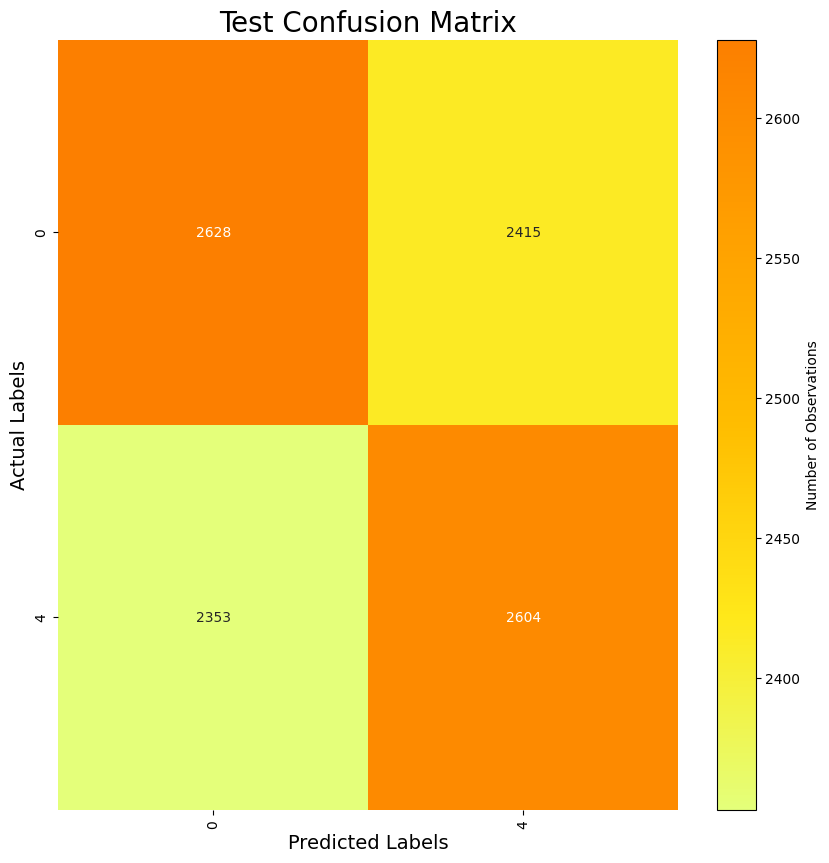

In [42]:
cm_test = confusion_matrix(y_test, y_test_pred)

cm_df = pd.DataFrame(cm_test, columns=np.unique(y_test), index = np.unique(y_test))
cm_df.index.name = 'Actual'
cm_df.columns.name = 'Predicted'

fig, ax = plt.subplots(figsize=(10, 10))

sns.heatmap(cm_df, annot=True, fmt='d', cmap='Wistia', ax=ax, cbar=False)

cbar = ax.figure.colorbar(ax.collections[0])
cbar.set_label('Number of Observations')

plt.title('Test Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)

ax.set_xticks(np.arange(cm_df.shape[1]) + 0.5, minor=False)
ax.set_yticks(np.arange(cm_df.shape[0]) + 0.5, minor=False)
ax.grid(True, which='minor')

plt.xticks(rotation=90)

plt.show()

Well it looks better than the previous one...

## TF-IDF

In [44]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()

corpus_tf = vectorizer.fit_transform(corpus)

x_train_tf, x_test_tf, y_train, y_test = train_test_split(corpus_tf, labels, test_size=0.1, random_state=42)
x_train_tf, x_valid_tf, y_train, y_valid = train_test_split(x_train_tf, y_train, test_size=0.11, random_state=42)

x_train_tf.shape, x_valid_tf.shape, x_test_tf.shape

((80100, 63621), (9900, 63621), (10000, 63621))

In [45]:
svc = SVC(random_state=42)
svc.fit(x_train_tf, y_train)

SVC(random_state=42)

In [47]:
y_train_pred = svc.predict(x_train_tf)
y_valid_pred = svc.predict(x_valid_tf)
y_test_pred = svc.predict(x_test_tf)

In [48]:
acc_train = accuracy_score(y_train, y_train_pred)
acc_valid = accuracy_score(y_valid, y_valid_pred)
acc_test = accuracy_score(y_test, y_test_pred)

print(f'Train accuracy: {acc_train*100:.2f}%')
print(f'Validation accuracy: {acc_valid*100:.2f}%\n')
print(f'Test accuracy: {acc_test*100:.2f}%')

Train accuracy: 94.92%
Validation accuracy: 77.62%

Test accuracy: 77.27%


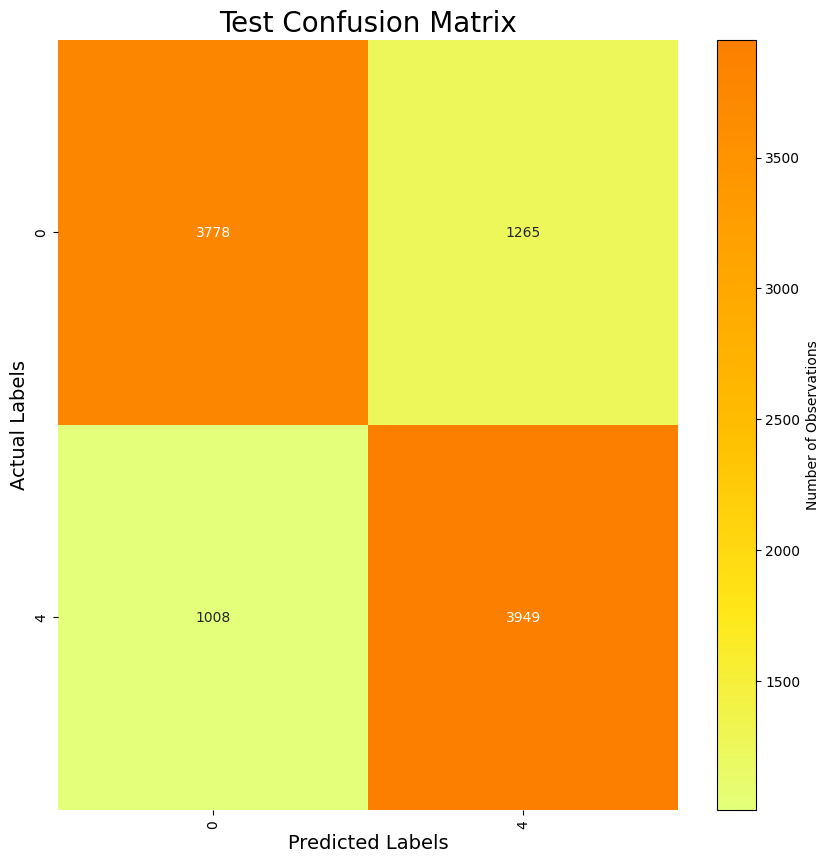

In [50]:
cm_test = confusion_matrix(y_test, y_test_pred)

cm_df = pd.DataFrame(cm_test, columns=np.unique(y_test), index = np.unique(y_test))
cm_df.index.name = 'Actual'
cm_df.columns.name = 'Predicted'

fig, ax = plt.subplots(figsize=(10, 10))

sns.heatmap(cm_df, annot=True, fmt='d', cmap='Wistia', ax=ax, cbar=False)

cbar = ax.figure.colorbar(ax.collections[0])
cbar.set_label('Number of Observations')

plt.title('Test Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)

ax.set_xticks(np.arange(cm_df.shape[1]) + 0.5, minor=False)
ax.set_yticks(np.arange(cm_df.shape[0]) + 0.5, minor=False)
ax.grid(True, which='minor')

plt.xticks(rotation=90)

plt.show()

### Random Forest

In [51]:
rfc = RandomForestClassifier(n_estimators=100)

rfc.fit(x_train_tf, y_train)

RandomForestClassifier()

In [52]:
y_train_pred = rfc.predict(x_train_tf)
y_valid_pred = rfc.predict(x_valid_tf)
y_test_pred = rfc.predict(x_test_tf)

In [53]:
acc_train = accuracy_score(y_train, y_train_pred)
acc_valid = accuracy_score(y_valid, y_valid_pred)
acc_test = accuracy_score(y_test, y_test_pred)

print(f'Train accuracy: {acc_train*100:.2f}%')
print(f'Validation accuracy: {acc_valid*100:.2f}%\n')
print(f'Test accuracy: {acc_test*100:.2f}%')

Train accuracy: 99.46%
Validation accuracy: 75.63%

Test accuracy: 75.54%


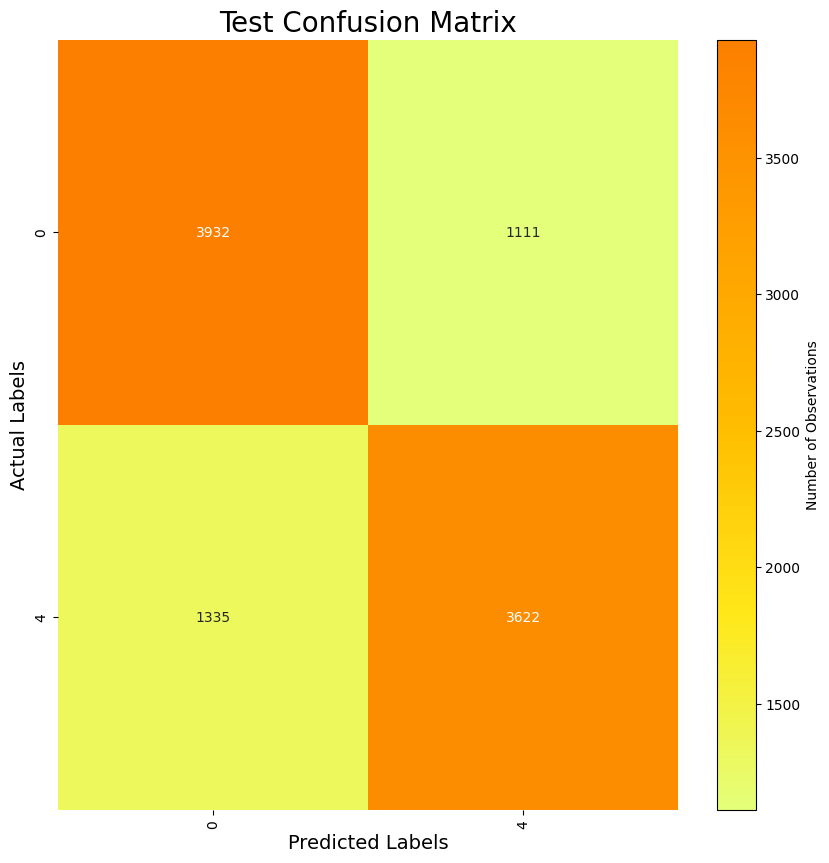

In [54]:
cm_test = confusion_matrix(y_test, y_test_pred)

cm_df = pd.DataFrame(cm_test, columns=np.unique(y_test), index = np.unique(y_test))
cm_df.index.name = 'Actual'
cm_df.columns.name = 'Predicted'

fig, ax = plt.subplots(figsize=(10, 10))

sns.heatmap(cm_df, annot=True, fmt='d', cmap='Wistia', ax=ax, cbar=False)

cbar = ax.figure.colorbar(ax.collections[0])
cbar.set_label('Number of Observations')

plt.title('Test Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)

ax.set_xticks(np.arange(cm_df.shape[1]) + 0.5, minor=False)
ax.set_yticks(np.arange(cm_df.shape[0]) + 0.5, minor=False)
ax.grid(True, which='minor')

plt.xticks(rotation=90)

plt.show()

It seems TF-IDF with Random Forest is behaving best.

*Use a pre-trained library like BERT or SpaCy for sentiment analysis.*

In [60]:
%pip install spacy
%python -m spacy download en

Note: you may need to restart the kernel to use updated packages.


UsageError: Line magic function `%python` not found (But cell magic `%%python` exists, did you mean that instead?).


In [107]:
import spacy
from spacy.util import minibatch, compounding

# Load a blank English model
nlp = spacy.blank("en")

# Add the text classifier to the pipeline
textcat = nlp.add_pipe("textcat")

In [108]:
# Add labels to the text classifier
textcat.add_label("POSITIVE")
textcat.add_label("NEGATIVE")

# Convert the labels in your DataFrame to 'POSITIVE' and 'NEGATIVE'
df_sampled['sentiment'] = df_sampled['label'].apply(lambda x: 'POSITIVE' if x == 4 else 'NEGATIVE')
df_sampled[['tweet','sentiment']]

,tweet,sentiment
307406,"I lost the other half of earring, that Ben and...",NEGATIVE
1538436,@lalavazquez New Hairstyle is cute! Awww Come...,POSITIVE
1501556,@LpThePharaoh it wass fuuunnnn me &amp; @chan...,POSITIVE
1558040,@xonoelbabe I just read your blog thingy..... ...,POSITIVE
194860,Cant sleep just sitting around bored,NEGATIVE
...,...,...
696281,just realized that I'll be missing both of my ...,NEGATIVE
383135,Bummed out because I missed out getting ticket...,NEGATIVE
738781,said scarf/hat/glove is lost,NEGATIVE
58108,i was under the impression that there was neve...,NEGATIVE


In [111]:
from spacy.training import Example

# Split your DataFrame into training, validation, and test sets
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    df_sampled['tweet'].values, df_sampled['sentiment'].values, test_size=0.2)
val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels, test_size=0.5)

# Combine the texts and labels into a single list
train_data = list(zip(train_texts, [{'cats': {'POSITIVE': label == 'POSITIVE', 'NEGATIVE': label == 'NEGATIVE'}}
                                    for label in train_labels]))
val_data = list(zip(val_texts, [{'cats': {'POSITIVE': label == 'POSITIVE', 'NEGATIVE': label == 'NEGATIVE'}}
                                for label in val_labels]))
test_data = list(zip(test_texts, [{'cats': {'POSITIVE': label == 'POSITIVE', 'NEGATIVE': label == 'NEGATIVE'}}
                                  for label in test_labels]))

# Convert the training data to a list of Example objects
train_examples = [Example.from_dict(nlp.make_doc(text), annotations) 
                  for text, annotations in train_data]
val_examples = [Example.from_dict(nlp.make_doc(text), annotations) 
                for text, annotations in val_data]
test_examples = [Example.from_dict(nlp.make_doc(text), annotations) 
                 for text, annotations in test_data]

In [112]:
# Train the model
n_iter = 10
spacy.util.fix_random_seed(1)
optimizer = nlp.begin_training()

batches = minibatch(train_examples, size=compounding(4.0, 32.0, 1.001))
for i in range(n_iter):
    for batch in batches:
        nlp.update(batch, sgd=optimizer)

[2024-02-02 15:46:45,890] [INFO] Created vocabulary
[2024-02-02 15:46:45,891] [INFO] Finished initializing nlp object


In [113]:
from sklearn.metrics import classification_report

# Use the trained model to predict the labels of the validation texts
val_predictions = [textcat(nlp.make_doc(example.text)).cats for example in val_examples]

# Convert the predictions to label strings
val_predictions_labels = ['POSITIVE' if preds['POSITIVE'] > preds['NEGATIVE']
                          else 'NEGATIVE' for preds in val_predictions]

# Print a classification report for the validation set
print("Validation Set Performance:")
print(classification_report(val_labels, val_predictions_labels, 
                            target_names=["NEGATIVE", "POSITIVE"]))

# Use the trained model to predict the labels of the test texts
test_predictions = [textcat(nlp.make_doc(example.text)).cats for example in test_examples]

# Convert the predictions to label strings
test_predictions_labels = ['POSITIVE' if preds['POSITIVE'] > preds['NEGATIVE'] 
                           else 'NEGATIVE' for preds in test_predictions]

# Print a classification report for the test set
print("Test Set Performance:")
print(classification_report(test_labels, test_predictions_labels, 
                            target_names=["NEGATIVE", "POSITIVE"]))

Validation Set Performance:
              precision    recall  f1-score   support

    NEGATIVE       0.79      0.79      0.79      4980
    POSITIVE       0.79      0.79      0.79      5020

    accuracy                           0.79     10000
   macro avg       0.79      0.79      0.79     10000
weighted avg       0.79      0.79      0.79     10000

Test Set Performance:
              precision    recall  f1-score   support

    NEGATIVE       0.78      0.79      0.78      4965
    POSITIVE       0.79      0.78      0.78      5035

    accuracy                           0.78     10000
   macro avg       0.78      0.78      0.78     10000
weighted avg       0.78      0.78      0.78     10000



# HuggingFace Model: DISTILBERT

In [133]:
corpus = df_sampled['tweet_filtered']
labels = df_sampled['label']

x_train, x_test, y_train, y_test = train_test_split(corpus, labels, test_size=0.1, random_state=42)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=1/9, random_state=42)

In [143]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("huggingface")
secret_value_1 = user_secrets.get_secret("wandb")

In [144]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import DataLoader, Dataset
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_name = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = DistilBertTokenizer.from_pretrained(model_name)
model = DistilBertForSequenceClassification.from_pretrained(model_name)

model = model.to(device)

In [145]:
train_encodings = tokenizer(x_train.tolist(),
    truncation=True, padding=True, return_tensors='pt')
val_encodings = tokenizer(x_valid.tolist(),
    truncation=True, padding=True, return_tensors='pt')
test_encodings = tokenizer(x_test.tolist(),
    truncation=True, padding=True, return_tensors='pt')

In [146]:
y_train_ten = torch.tensor(np.where(y_train == 0, 0, 1)).long()
y_valid_ten = torch.tensor(np.where(y_valid == 0, 0, 1)).long()
y_test_ten = torch.tensor(np.where(y_test == 0, 0, 1)).long()

In [147]:
class TwitterDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx].clone().detach()
                for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx].clone().detach()
        return item

    def __len__(self):
        return len(self.labels)
    
train_dataset = TwitterDataset(train_encodings, y_train_ten)
valid_dataset = TwitterDataset(val_encodings, y_valid_ten)
test_dataset = TwitterDataset(test_encodings, y_test_ten)

In [148]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)

In [149]:
training_args = TrainingArguments(
    output_dir='./DISTILBERT_out',
    num_train_epochs=5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./DISTILBERT_logs',
)
trainer = Trainer(
    model=model,                        
    args=training_args,                 
    train_dataset=train_dataset,        
    eval_dataset=valid_dataset          
)

trainer.train()

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss
500,0.612700
1000,0.491800
1500,0.474800
2000,0.452300
2500,0.460000
3000,0.370300
3500,0.371700
4000,0.362500
4500,0.364100
5000,0.368700


Checkpoint destination directory ./DISTILBERT_out/checkpoint-500 already exists and is non-empty.Saving will proceed but saved results may be invalid.
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
Checkpoint destination directory ./DISTILBERT_out/checkpoint-1000 already exists and is non-empty.Saving will proceed but saved results may be invalid.
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
Checkpoint destination directory ./DISTILBERT_out/checkpoint-1500 already exists and is non-empty.Saving will proceed but saved results may be invali

TrainOutput(global_step=12500, training_loss=0.2617531149291992, metrics={'train_runtime': 1692.1926, 'train_samples_per_second': 236.38, 'train_steps_per_second': 7.387, 'total_flos': 5174507760000000.0, 'train_loss': 0.2617531149291992, 'epoch': 5.0})

In [152]:
train_predictions = trainer.predict(train_dataset)
val_predictions = trainer.predict(valid_dataset)
test_predictions = trainer.predict(test_dataset)

train_preds = np.argmax(train_predictions.predictions, axis=1)
val_preds = np.argmax(val_predictions.predictions, axis=1)
test_preds = np.argmax(test_predictions.predictions, axis=1)

train_acc = accuracy_score(y_train_ten, train_preds)
val_acc = accuracy_score(y_valid_ten, val_preds)
test_acc = accuracy_score(y_test_ten, test_preds)

print(f'Train Accuracy: {train_acc*100:.2f}%')
print(f'Validation Accuracy: {val_acc*100:.2f}%')
print(f'Test Accuracy: {test_acc*100:.2f}%')

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Train Accuracy: 99.06%
Validation Accuracy: 78.95%
Test Accuracy: 77.85%


In [153]:
# Save the model
trainer.save_model("./DISTIL_BERT_results")

In [154]:
tokenizer.save_pretrained("./DISTIL_BERT_results")

('./DISTIL_BERT_results/tokenizer_config.json',
 './DISTIL_BERT_results/special_tokens_map.json',
 './DISTIL_BERT_results/vocab.txt',
 './DISTIL_BERT_results/added_tokens.json')